In [1]:
import os
seed = 42
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import pickle

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = './experiment_set_14'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [8]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

In [9]:
def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     cmapss_score))
    return mse, rmse, cmapss_score
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', dropout=0, output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    
    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def save_object(obj, output_file):
    with open(output_file, 'wb') as file:
        pickle.dump(obj, file)
    print("Saved object to file: {}".format(output_file))
    
def load_object(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)
    
def numbers_list_to_string(num_list):
    return " ".join([str(x) for x in num_list])

In [10]:
def test_mlp_configuration(x_train, y_train, num_trials, iter_num, num_epochs, 
                           batch_size, layer_sizes, activation, dropout,
                           weights_path, history_path):
    mse_train_vals = []
    mse_validation_vals = []
    
    input_dim = x_train.shape[1]
    
    for j in range(num_trials):
        # Train-validation split
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.3, 
                                                                                  random_state=j)
        # Standardization
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        
        # Initialize weights only in first split
        weights_file = os.path.join(weights_path, f'mlp_weights_{iter_num}.h5')
        if j == 0:
            model = create_mlp_model(input_dim, layer_sizes, activation=activation,
                                     dropout=dropout,
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim, layer_sizes, activation=activation,
                                     dropout=dropout)
        model.summary()

        # Train model
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        history = train_model_existing_weights(model, weights_file, 
                                               x_train_scaled, y_train_split, 
                                               x_val_scaled, y_val_split, 
                                               batch_size=batch_size, 
                                               epochs=num_epochs,
                                               callbacks=[es])

        history_file = os.path.join(history_path, f"history_{i}_{j}.pkl")
        plot_loss_curves(history.history)
        save_history(history, history_file)

        mse_train_vals.append(history.history['loss'][-1])
        mse_validation_vals.append(history.history['val_loss'][-1])

    mse_train = np.mean(mse_train_vals)
    mse_train_std = np.std(mse_train_vals)
    mse_validation = np.mean(mse_validation_vals)
    mse_validation_std = np.std(mse_validation_vals)
    
    return mse_train, mse_train_std, mse_validation, mse_validation_std

In [11]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print("Train set shape: " + str(train_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 
columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

Operation time (sec):  3.609375
Train set shape: (5263447, 47)


In [12]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

In [13]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
selected_columns = columns_operating_conditions + columns_sensor_measurements
x_train = x_train[selected_columns]
x_test = x_test[selected_columns]

In [14]:
###################################
# Random search (experiment set 13)
###################################
ITERATIONS = 100 
EPOCHS = 15
NUM_TRIALS = 1

hidden_layer_sizes = [64, 128, 256, 512]
num_hidden_layers = [1, 2, 3, 4]
activation_functions = ['relu', 'tanh']
batch_sizes = [512, 1024, 2048]
dropout_percentages = list(np.arange(0, 6)/10)
input_dim = x_train.shape[1]

In [15]:
results_file = os.path.join(output_path, "parameter_search.csv")
with open(results_file, "w") as file:
    file.write("layers,activation,batch_size,dropout,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std\n")



Iteration  0
Layer sizes = [64], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 23s 3ms/step - loss: 251.9720 - val_loss: 110.4784
Epoch 2/15
7197/7197 [==============================] - 23s 3ms/step - loss: 104.6347 - val_loss: 81.8338
Epoch 3/15
7197/7197 [==============================] - 26s 4ms/step - loss: 91.0831 

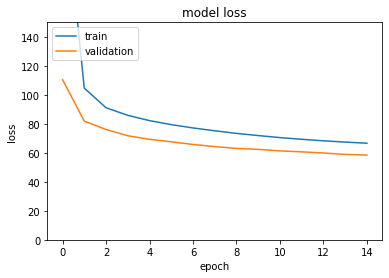

Saved training history to file: ./experiment_set_13\history\history_0_0.pkl


Iteration  1
Layer sizes = [64, 64], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 22s 3ms/step - loss: 150.3821 - val_loss: 55.2835
Epoch 2/15
7197/7197 [==============================] - 23s 3ms/step - loss: 52.6171 - val_loss: 51.4737
Epoch

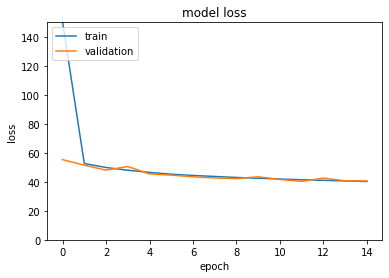

Saved training history to file: ./experiment_set_13\history\history_1_0.pkl


Iteration  2
Layer sizes = [128], activation = relu, batch size = 2048, dropout = 0.4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2432      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 6s 3ms/step - loss: 462.6950 - val_loss: 140.1231
Epoch 2/15
1800/1800 [==============================] - 6s 3ms/step - loss: 148.2652 - val_loss: 104.5321
Epoch 

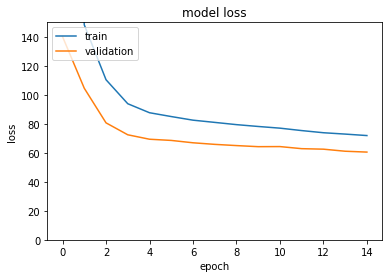

Saved training history to file: ./experiment_set_13\history\history_2_0.pkl


Iteration  3
Layer sizes = [128], activation = tanh, batch size = 512, dropout = 0.3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               2432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 23s 3ms/step - loss: 226.1692 - val_loss: 130.2179
Epoch 2/15
7197/7197 [==============================] - 22s 3ms/step - loss: 127.3404 - val_loss: 96.1845
Epoch 

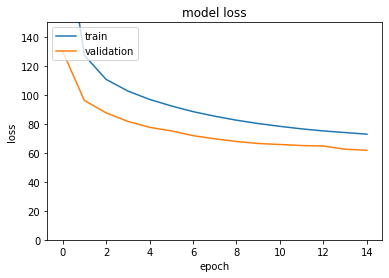

Saved training history to file: ./experiment_set_13\history\history_3_0.pkl


Iteration  4
Layer sizes = [64, 128, 512], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_5 (Dr

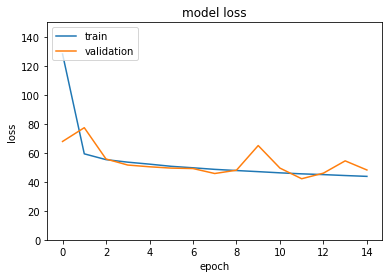

Saved training history to file: ./experiment_set_13\history\history_4_0.pkl


Iteration  5
Layer sizes = [256, 64], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 3ms/step - loss: 127.4664 - val_loss: 54.4935
Epoch 2/15
3599/3599 [==============================] - 12s 3ms/step - loss: 50.8694 - val_loss: 51.4874
E

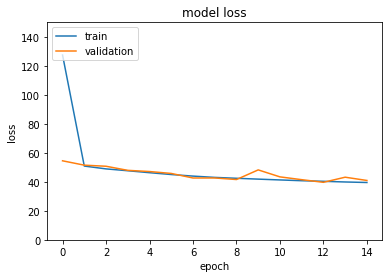

Saved training history to file: ./experiment_set_13\history\history_5_0.pkl


Iteration  6
Layer sizes = [256, 256, 64], activation = tanh, batch size = 2048, dropout = 0.0
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 87,169
Trainable params: 87,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 10s 6ms/step - loss

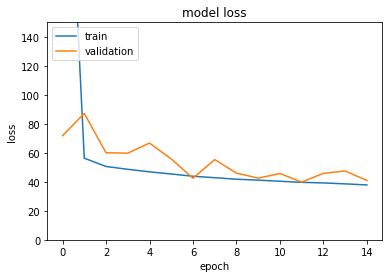

Saved training history to file: ./experiment_set_13\history\history_6_0.pkl


Iteration  7
Layer sizes = [64, 256, 256, 128], activation = relu, batch size = 512, dropout = 0.5
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8

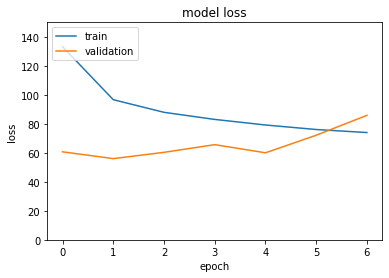

Saved training history to file: ./experiment_set_13\history\history_7_0.pkl


Iteration  8
Layer sizes = [256, 64], activation = relu, batch size = 512, dropout = 0.3
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_______________

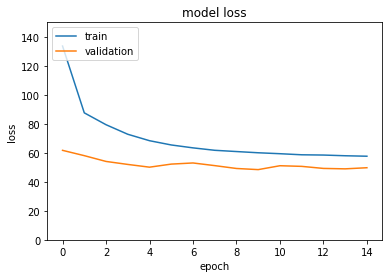

Saved training history to file: ./experiment_set_13\history\history_8_0.pkl


Iteration  9
Layer sizes = [512, 256, 128], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (

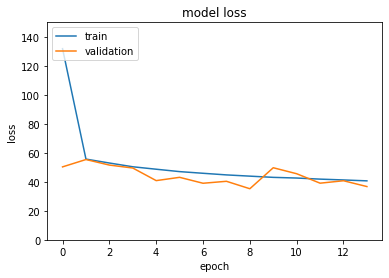

Saved training history to file: ./experiment_set_13\history\history_9_0.pkl


Iteration  10
Layer sizes = [64, 128, 128], activation = relu, batch size = 1024, dropout = 0.3
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 

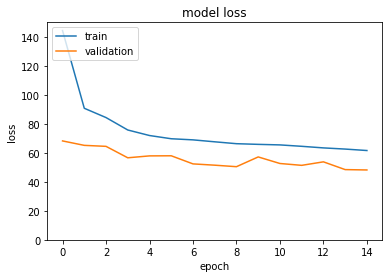

Saved training history to file: ./experiment_set_13\history\history_10_0.pkl


Iteration  11
Layer sizes = [128, 256, 64], activation = relu, batch size = 512, dropout = 0.2
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_20 

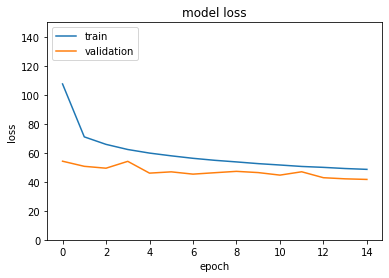

Saved training history to file: ./experiment_set_13\history\history_11_0.pkl


Iteration  12
Layer sizes = [256, 64, 128, 256], activation = relu, batch size = 2048, dropout = 0.3
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropo

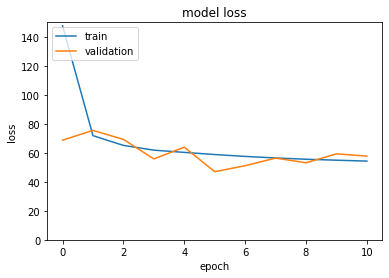

Saved training history to file: ./experiment_set_13\history\history_12_0.pkl


Iteration  13
Layer sizes = [512, 128, 256, 128], activation = relu, batch size = 2048, dropout = 0.4
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               33024     
_________________________________________________________________
drop

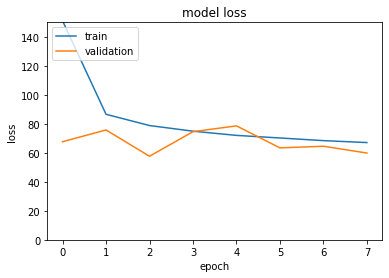

Saved training history to file: ./experiment_set_13\history\history_13_0.pkl


Iteration  14
Layer sizes = [512, 512, 256], activation = relu, batch size = 512, dropout = 0.4
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_31

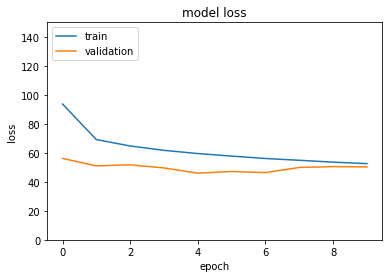

Saved training history to file: ./experiment_set_13\history\history_14_0.pkl


Iteration  15
Layer sizes = [64, 64, 64, 128], activation = relu, batch size = 2048, dropout = 0.3
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout

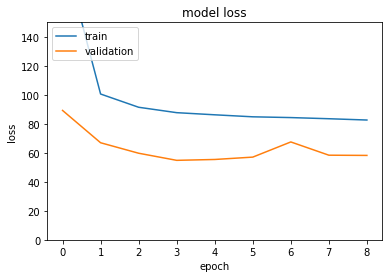

Saved training history to file: ./experiment_set_13\history\history_15_0.pkl


Iteration  16
Layer sizes = [512], activation = tanh, batch size = 2048, dropout = 0.3
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 513       
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 10s 5ms/step - loss: 276.0066 - val_loss: 150.7574
Epoch 2/15
1800/1800 [==============================] - 9s 5ms/step - loss: 151.6007 - val_loss: 149.2609


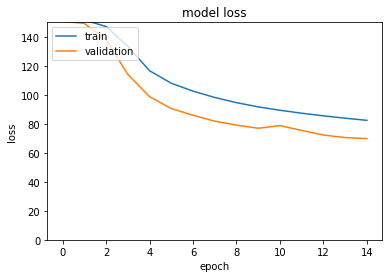

Saved training history to file: ./experiment_set_13\history\history_16_0.pkl


Iteration  17
Layer sizes = [64, 64, 256], activation = tanh, batch size = 512, dropout = 0.2
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_39 (

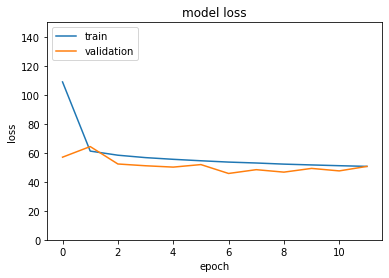

Saved training history to file: ./experiment_set_13\history\history_17_0.pkl


Iteration  18
Layer sizes = [128, 512, 64, 256], activation = relu, batch size = 2048, dropout = 0.0
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_66 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_67 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_68 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 257       
Total params: 118,209
Trainable params: 118,209
Non-trainable params: 0

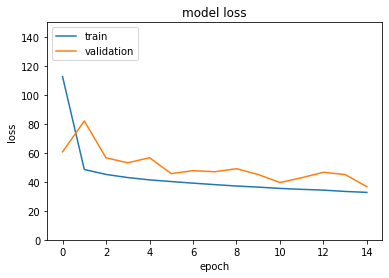

Saved training history to file: ./experiment_set_13\history\history_18_0.pkl


Iteration  19
Layer sizes = [128, 128, 256], activation = relu, batch size = 2048, dropout = 0.4
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4

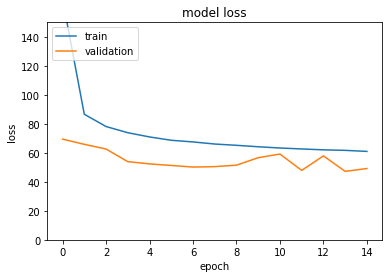

Saved training history to file: ./experiment_set_13\history\history_19_0.pkl


Iteration  20
Layer sizes = [256], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 22s 3ms/step - loss: 188.3716 - val_loss: 112.7017
Epoch 2/15
7197/7197 [==============================] - 22s 3ms/step - loss: 87.5876 - val_loss: 73.1671
Epoch 3/15
7197/7197 [==============================] - 23s 3ms/step - loss: 68.8566 - val_loss: 66.1553
Epoch 4/15
7197/7197 [=========

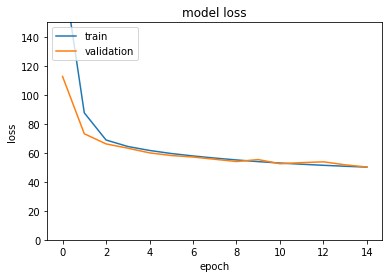

Saved training history to file: ./experiment_set_13\history\history_20_0.pkl


Iteration  21
Layer sizes = [256, 128, 64], activation = relu, batch size = 2048, dropout = 0.0
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 65        
Total params: 46,081
Trainable params: 46,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 9s 5ms/step - lo

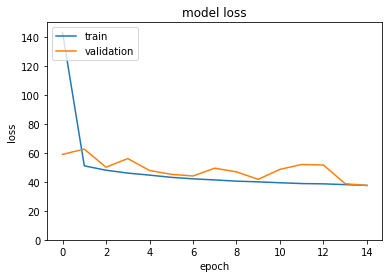

Saved training history to file: ./experiment_set_13\history\history_21_0.pkl


Iteration  22
Layer sizes = [512], activation = relu, batch size = 2048, dropout = 0.1
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_43 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 513       
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 10s 6ms/step - loss: 276.7162 - val_loss: 94.8697
Epoch 2/15
1800/1800 [==============================] - 10s 5ms/step - loss: 84.4809 - val_loss: 74.0742
Ep

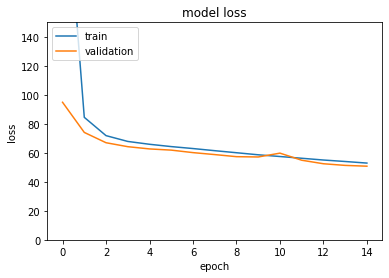

Saved training history to file: ./experiment_set_13\history\history_22_0.pkl


Iteration  23
Layer sizes = [512, 128], activation = tanh, batch size = 2048, dropout = 0.4
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 129       
Total params: 75,521
Trainable params: 75,521
Non-trainable params: 0
__________

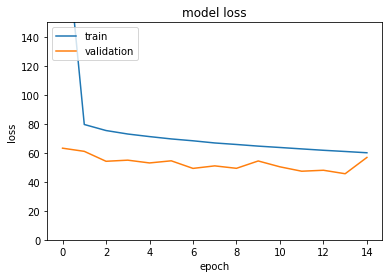

Saved training history to file: ./experiment_set_13\history\history_23_0.pkl


Iteration  24
Layer sizes = [128, 128, 256, 512], activation = tanh, batch size = 1024, dropout = 0.4
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 256)               33024     
_________________________________________________________________
drop

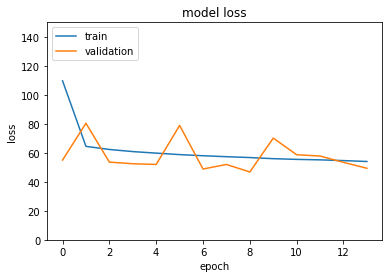

Saved training history to file: ./experiment_set_13\history\history_24_0.pkl


Iteration  25
Layer sizes = [64, 128, 128, 64], activation = tanh, batch size = 512, dropout = 0.4
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout

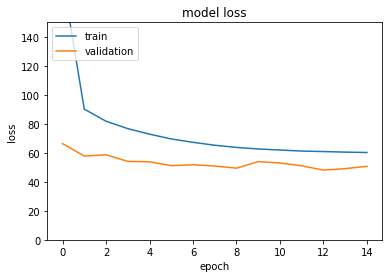

Saved training history to file: ./experiment_set_13\history\history_25_0.pkl


Iteration  26
Layer sizes = [128, 64], activation = relu, batch size = 2048, dropout = 0.5
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 65        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
___________

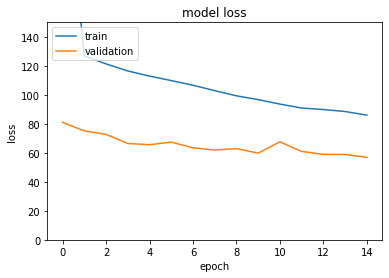

Saved training history to file: ./experiment_set_13\history\history_26_0.pkl


Iteration  27
Layer sizes = [128], activation = relu, batch size = 512, dropout = 0.2
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 23s 3ms/step - loss: 203.7339 - val_loss: 79.1223
Epoch 2/15
7197/7197 [==============================] - 23s 3ms/step - loss: 79.2058 - val_loss: 67.2766
Epoch

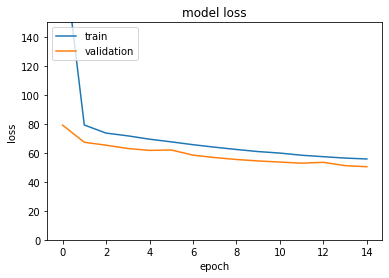

Saved training history to file: ./experiment_set_13\history\history_27_0.pkl


Iteration  28
Layer sizes = [128], activation = tanh, batch size = 2048, dropout = 0.3
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 7s 4ms/step - loss: 414.6827 - val_loss: 164.6060
Epoch 2/15
1800/1800 [==============================] - 6s 4ms/step - loss: 165.1046 - val_loss: 150.8011
Epo

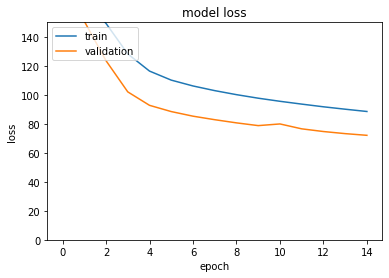

Saved training history to file: ./experiment_set_13\history\history_28_0.pkl


Iteration  29
Layer sizes = [128, 512], activation = relu, batch size = 1024, dropout = 0.3
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_59 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 513       
Total params: 68,993
Trainable params: 68,993
Non-trainable params: 0
__________

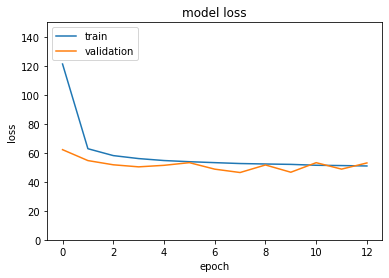

Saved training history to file: ./experiment_set_13\history\history_29_0.pkl


Iteration  30
Layer sizes = [64, 64], activation = tanh, batch size = 1024, dropout = 0.3
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
______________

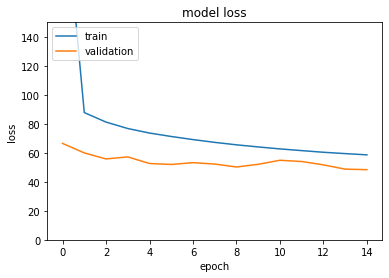

Saved training history to file: ./experiment_set_13\history\history_30_0.pkl


Iteration  31
Layer sizes = [512, 64, 64, 64], activation = tanh, batch size = 2048, dropout = 0.2
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout

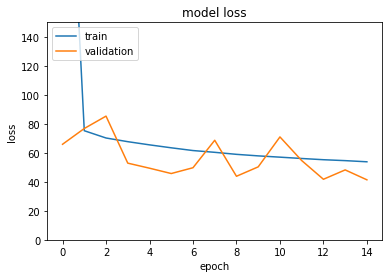

Saved training history to file: ./experiment_set_13\history\history_31_0.pkl


Iteration  32
Layer sizes = [128], activation = relu, batch size = 512, dropout = 0.4
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 21s 3ms/step - loss: 213.2422 - val_loss: 77.9600
Epoch 2/15
7197/7197 [==============================] - 21s 3ms/step - loss: 87.8306 - val_loss: 68.3955
Epoch

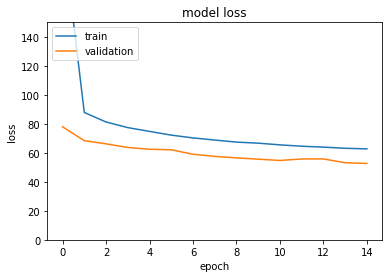

Saved training history to file: ./experiment_set_13\history\history_32_0.pkl


Iteration  33
Layer sizes = [128, 512, 128, 256], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_116 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_117 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_118 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 257       
Total params: 167,425
Trainable params: 167,425
Non-trainable params: 0

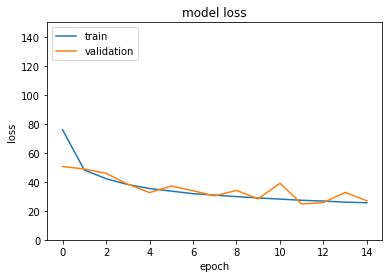

Saved training history to file: ./experiment_set_13\history\history_33_0.pkl


Iteration  34
Layer sizes = [64, 64, 64, 64], activation = relu, batch size = 512, dropout = 0.3
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_67 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_68 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_6

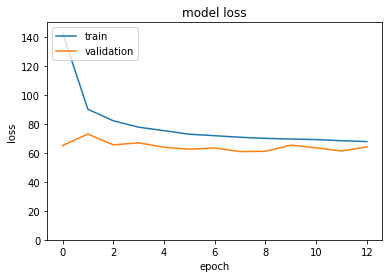

Saved training history to file: ./experiment_set_13\history\history_34_0.pkl


Iteration  35
Layer sizes = [512, 128, 512, 64], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 512)               9728      
_________________________________________________________________
dense_126 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_127 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_128 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 65        
Total params: 174,337
Trainable params: 174,337
Non-trainable params: 0

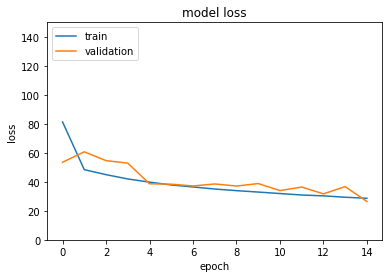

Saved training history to file: ./experiment_set_13\history\history_35_0.pkl


Iteration  36
Layer sizes = [256, 512, 256, 512], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_72 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropo

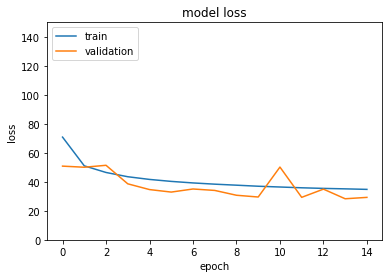

Saved training history to file: ./experiment_set_13\history\history_36_0.pkl


Iteration  37
Layer sizes = [128, 64, 64], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_136 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_137 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 65        
Total params: 14,913
Trainable params: 14,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 26s 4ms/step - los

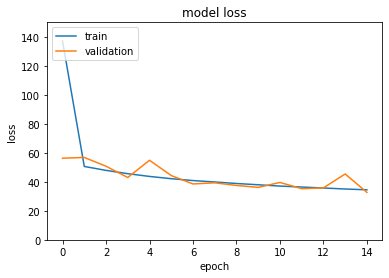

Saved training history to file: ./experiment_set_13\history\history_37_0.pkl


Iteration  38
Layer sizes = [128, 64, 64, 128], activation = relu, batch size = 2048, dropout = 0.0
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_140 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_141 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_142 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 129       
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
__

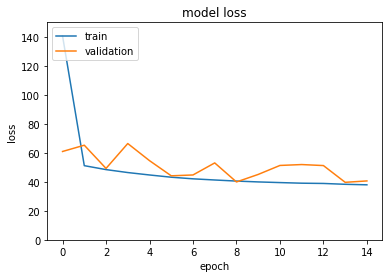

Saved training history to file: ./experiment_set_13\history\history_38_0.pkl


Iteration  39
Layer sizes = [512, 64], activation = relu, batch size = 2048, dropout = 0.4
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_75 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 65        
Total params: 42,625
Trainable params: 42,625
Non-trainable params: 0
___________

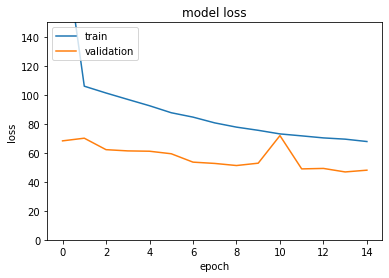

Saved training history to file: ./experiment_set_13\history\history_39_0.pkl


Iteration  40
Layer sizes = [64], activation = tanh, batch size = 2048, dropout = 0.4
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 7s 4ms/step - loss: 540.8359 - val_loss: 188.7624
Epoch 2/15
1800/1800 [==============================] - 6s 3ms/step - loss: 192.2036 - val_loss: 160.1811
Epoc

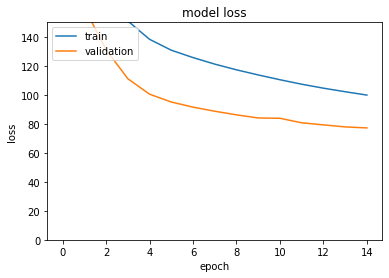

Saved training history to file: ./experiment_set_13\history\history_40_0.pkl


Iteration  41
Layer sizes = [256, 128, 256], activation = relu, batch size = 1024, dropout = 0.3
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_79 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_8

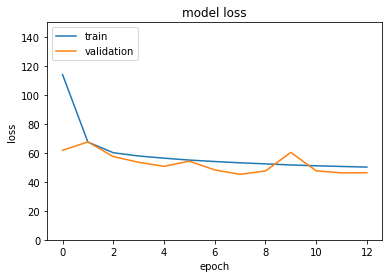

Saved training history to file: ./experiment_set_13\history\history_41_0.pkl


Iteration  42
Layer sizes = [256, 512], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 256)               4864      
_________________________________________________________________
dense_154 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 513       
Total params: 136,961
Trainable params: 136,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 28s 4ms/step - loss: 85.8470 - val_loss: 55.0444
Epoch 2/15
7197/7197 [==============================] - 28s 4ms/step - loss: 50.9612 - val_loss: 56.42

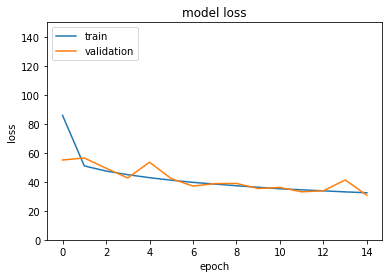

Saved training history to file: ./experiment_set_13\history\history_42_0.pkl


Iteration  43
Layer sizes = [64, 64, 128, 256], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_157 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_158 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_159 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 257       
Total params: 46,977
Trainable params: 46,977
Non-trainable params: 0
__

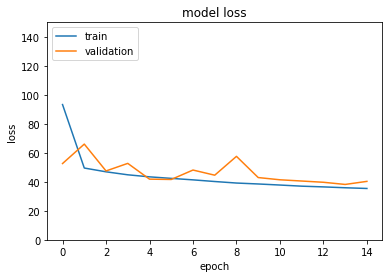

Saved training history to file: ./experiment_set_13\history\history_43_0.pkl


Iteration  44
Layer sizes = [256, 256], activation = relu, batch size = 1024, dropout = 0.4
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_82 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 257       
Total params: 70,913
Trainable params: 70,913
Non-trainable params: 0
__________

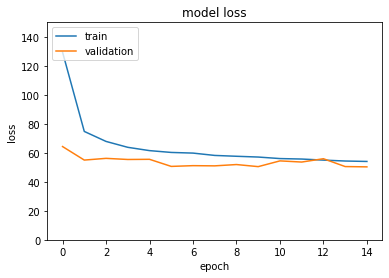

Saved training history to file: ./experiment_set_13\history\history_44_0.pkl


Iteration  45
Layer sizes = [64, 256, 64], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_165 (Dense)            (None, 256)               16640     
_________________________________________________________________
dense_166 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 14s 4ms/step - lo

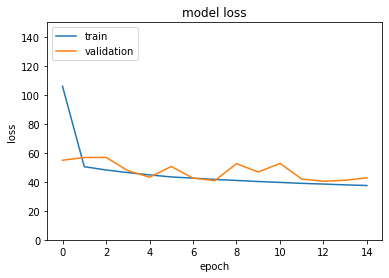

Saved training history to file: ./experiment_set_13\history\history_45_0.pkl


Iteration  46
Layer sizes = [128], activation = tanh, batch size = 1024, dropout = 0.4
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 12s 3ms/step - loss: 297.0391 - val_loss: 155.1263
Epoch 2/15
3599/3599 [==============================] - 11s 3ms/step - loss: 156.3051 - val_loss: 125.9167
E

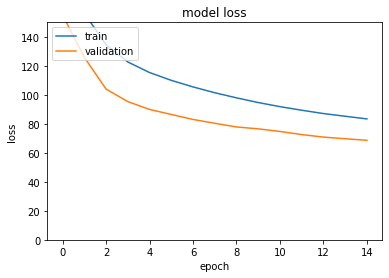

Saved training history to file: ./experiment_set_13\history\history_46_0.pkl


Iteration  47
Layer sizes = [256, 128], activation = tanh, batch size = 2048, dropout = 0.3
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_85 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 129       
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
__________

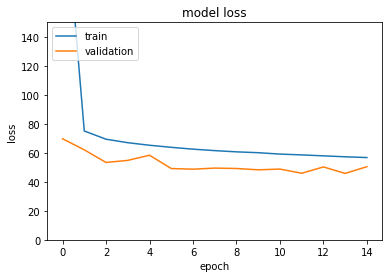

Saved training history to file: ./experiment_set_13\history\history_47_0.pkl


Iteration  48
Layer sizes = [64, 64, 512], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_174 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_175 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 513       
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 26s 4ms/step - los

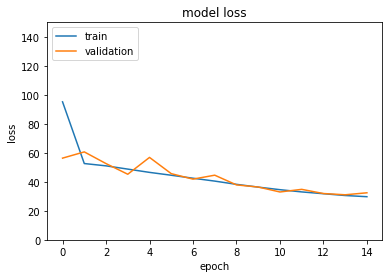

Saved training history to file: ./experiment_set_13\history\history_48_0.pkl


Iteration  49
Layer sizes = [128, 256, 128], activation = tanh, batch size = 2048, dropout = 0.5
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_86 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_87 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_8

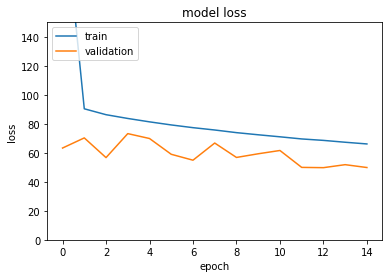

Saved training history to file: ./experiment_set_13\history\history_49_0.pkl


Iteration  50
Layer sizes = [64, 64, 64, 128], activation = relu, batch size = 1024, dropout = 0.4
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_89 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_90 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout

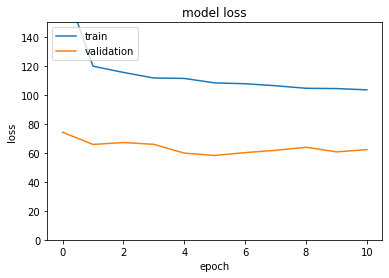

Saved training history to file: ./experiment_set_13\history\history_50_0.pkl


Iteration  51
Layer sizes = [512, 128], activation = relu, batch size = 1024, dropout = 0.2
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_93 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_94 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 129       
Total params: 75,521
Trainable params: 75,521
Non-trainable params: 0
__________

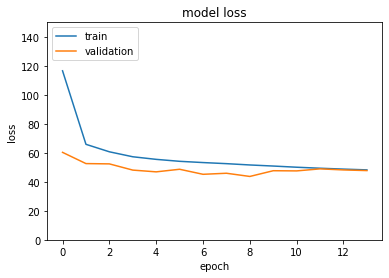

Saved training history to file: ./experiment_set_13\history\history_51_0.pkl


Iteration  52
Layer sizes = [256], activation = relu, batch size = 2048, dropout = 0.1
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_95 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 8s 4ms/step - loss: 346.3433 - val_loss: 116.9421
Epoch 2/15
1800/1800 [==============================] - 8s 4ms/step - loss: 101.7715 - val_loss: 84.4056
Epoc

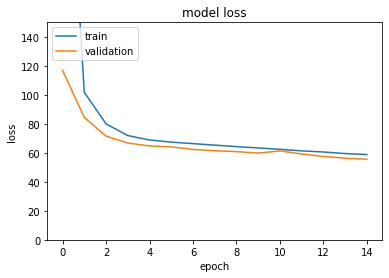

Saved training history to file: ./experiment_set_13\history\history_52_0.pkl


Iteration  53
Layer sizes = [256], activation = tanh, batch size = 2048, dropout = 0.5
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_96 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 8s 5ms/step - loss: 338.5029 - val_loss: 155.7594
Epoch 2/15
1800/1800 [==============================] - 8s 4ms/step - loss: 162.3485 - val_loss: 152.8965
Epo

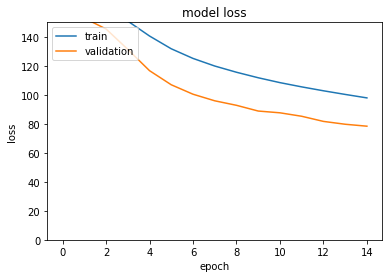

Saved training history to file: ./experiment_set_13\history\history_53_0.pkl


Iteration  54
Layer sizes = [128, 128], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_194 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 129       
Total params: 19,073
Trainable params: 19,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - loss: 121.3013 - val_loss: 55.1013
Epoch 2/15
3599/3599 [==============================] - 13s 4ms/step - loss: 51.3506 - val_loss: 51.63

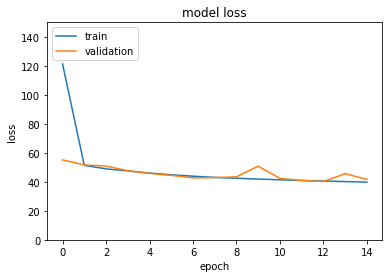

Saved training history to file: ./experiment_set_13\history\history_54_0.pkl


Iteration  55
Layer sizes = [256, 512], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_97 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_98 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 513       
Total params: 136,961
Trainable params: 136,961
Non-trainable params: 0
________

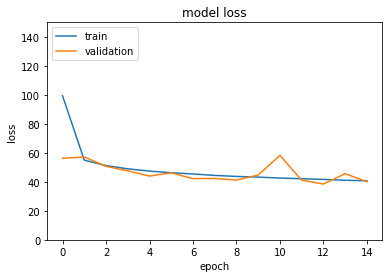

Saved training history to file: ./experiment_set_13\history\history_55_0.pkl


Iteration  56
Layer sizes = [512], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_99 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 513       
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 15s 4ms/step - loss: 187.9215 - val_loss: 77.7417
Epoch 2/15
3599/3599 [==============================] - 15s 4ms/step - loss: 72.1937 - val_loss: 67.3027
Ep

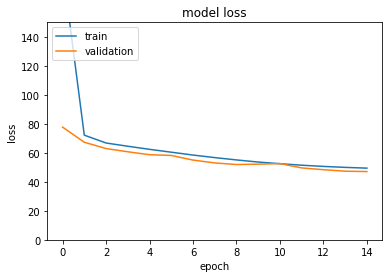

Saved training history to file: ./experiment_set_13\history\history_56_0.pkl


Iteration  57
Layer sizes = [512, 256], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 257       
Total params: 141,313
Trainable params: 141,313
Non-trainable params: 0
_________

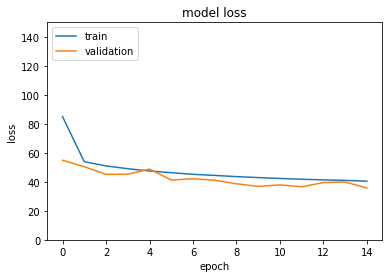

Saved training history to file: ./experiment_set_13\history\history_57_0.pkl


Iteration  58
Layer sizes = [128], activation = tanh, batch size = 1024, dropout = 0.2
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_102 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - loss: 288.6125 - val_loss: 150.7676
Epoch 2/15
3599/3599 [==============================] - 14s 4ms/step - loss: 136.5814 - val_loss: 104.3115
E

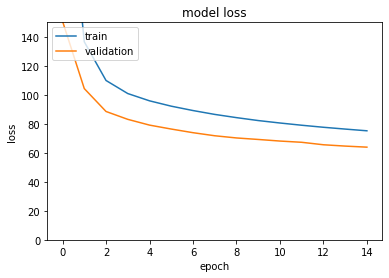

Saved training history to file: ./experiment_set_13\history\history_58_0.pkl


Iteration  59
Layer sizes = [256], activation = tanh, batch size = 2048, dropout = 0.4
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_103 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 8s 5ms/step - loss: 334.4174 - val_loss: 155.5080
Epoch 2/15
1800/1800 [==============================] - 8s 4ms/step - loss: 159.4504 - val_loss: 151.9647
Epo

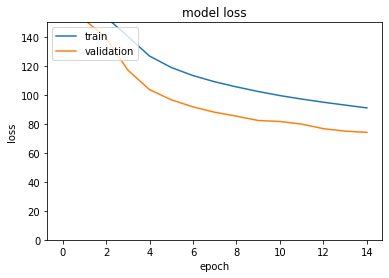

Saved training history to file: ./experiment_set_13\history\history_59_0.pkl


Iteration  60
Layer sizes = [256, 64, 64, 256], activation = relu, batch size = 2048, dropout = 0.2
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_104 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_105 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropou

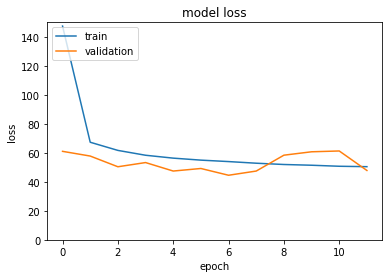

Saved training history to file: ./experiment_set_13\history\history_60_0.pkl


Iteration  61
Layer sizes = [64], activation = tanh, batch size = 1024, dropout = 0.5
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_213 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_108 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 12s 3ms/step - loss: 380.4937 - val_loss: 167.2248
Epoch 2/15
3599/3599 [==============================] - 12s 3ms/step - loss: 182.1606 - val_loss: 136.8054
Ep

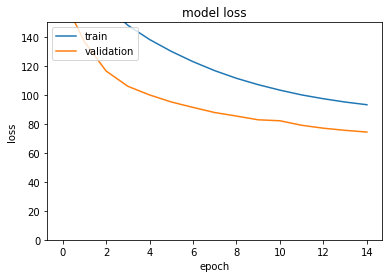

Saved training history to file: ./experiment_set_13\history\history_61_0.pkl


Iteration  62
Layer sizes = [512, 64, 512], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 512)               9728      
_________________________________________________________________
dense_216 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_217 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_218 (Dense)            (None, 1)                 513       
Total params: 76,353
Trainable params: 76,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 18s 5ms/step - l

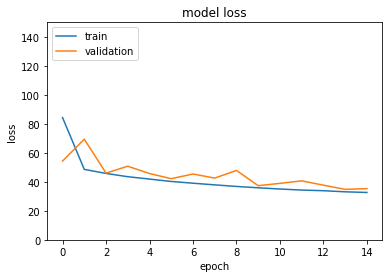

Saved training history to file: ./experiment_set_13\history\history_62_0.pkl


Iteration  63
Layer sizes = [64, 128, 256, 512], activation = relu, batch size = 2048, dropout = 0.2
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_109 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_110 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropo

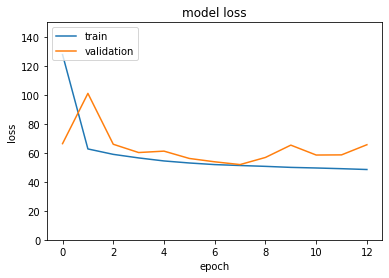

Saved training history to file: ./experiment_set_13\history\history_63_0.pkl


Iteration  64
Layer sizes = [64, 256, 256], activation = tanh, batch size = 1024, dropout = 0.3
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 256)               16640     
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_11

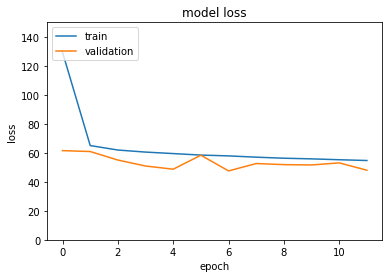

Saved training history to file: ./experiment_set_13\history\history_64_0.pkl


Iteration  65
Layer sizes = [128, 128, 512], activation = tanh, batch size = 2048, dropout = 0.5
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_116 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_229 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_230 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_1

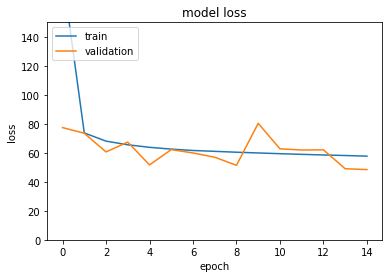

Saved training history to file: ./experiment_set_13\history\history_65_0.pkl


Iteration  66
Layer sizes = [256, 512], activation = relu, batch size = 1024, dropout = 0.2
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_119 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_233 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_120 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 1)                 513       
Total params: 136,961
Trainable params: 136,961
Non-trainable params: 0
________

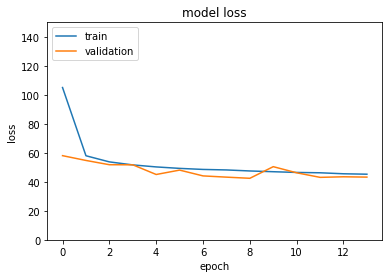

Saved training history to file: ./experiment_set_13\history\history_66_0.pkl


Iteration  67
Layer sizes = [512, 256], activation = tanh, batch size = 1024, dropout = 0.3
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_121 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_122 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 257       
Total params: 141,313
Trainable params: 141,313
Non-trainable params: 0
________

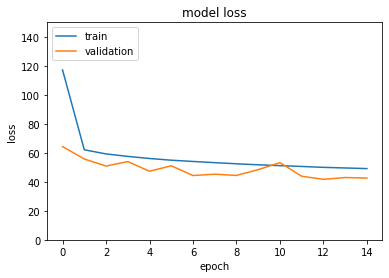

Saved training history to file: ./experiment_set_13\history\history_67_0.pkl


Iteration  68
Layer sizes = [512, 128], activation = relu, batch size = 1024, dropout = 0.4
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_238 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_123 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_239 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_124 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 1)                 129       
Total params: 75,521
Trainable params: 75,521
Non-trainable params: 0
__________

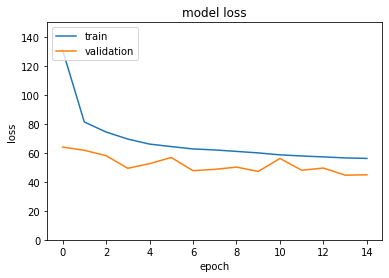

Saved training history to file: ./experiment_set_13\history\history_68_0.pkl


Iteration  69
Layer sizes = [64, 128, 256], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_125 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_242 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_126 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_243 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_127

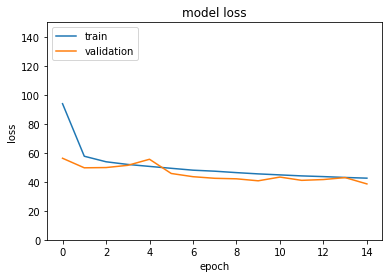

Saved training history to file: ./experiment_set_13\history\history_69_0.pkl


Iteration  70
Layer sizes = [64], activation = relu, batch size = 1024, dropout = 0.4
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_128 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_246 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 12s 3ms/step - loss: 409.0335 - val_loss: 140.0090
Epoch 2/15
3599/3599 [==============================] - 12s 3ms/step - loss: 151.3729 - val_loss: 88.1176
Epo

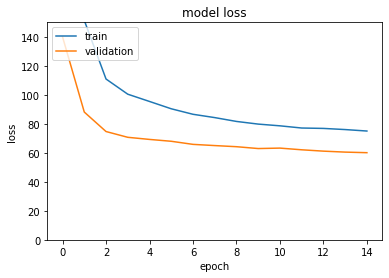

Saved training history to file: ./experiment_set_13\history\history_70_0.pkl


Iteration  71
Layer sizes = [512], activation = tanh, batch size = 2048, dropout = 0.4
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_247 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_129 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 1)                 513       
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 10s 6ms/step - loss: 276.8563 - val_loss: 150.8161
Epoch 2/15
1800/1800 [==============================] - 10s 6ms/step - loss: 152.9774 - val_loss: 150.1631

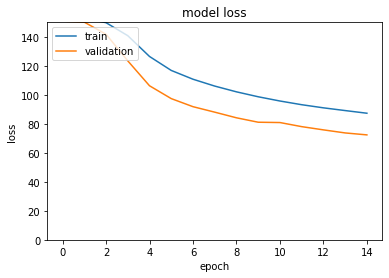

Saved training history to file: ./experiment_set_13\history\history_71_0.pkl


Iteration  72
Layer sizes = [512, 512], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_249 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_130 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_250 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_131 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 513       
Total params: 272,897
Trainable params: 272,897
Non-trainable params: 0
_________

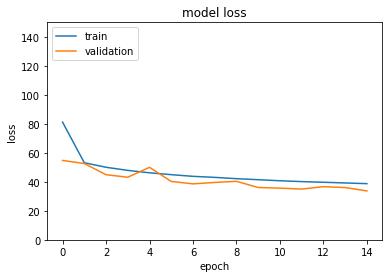

Saved training history to file: ./experiment_set_13\history\history_72_0.pkl


Iteration  73
Layer sizes = [64], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_132 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 23s 3ms/step - loss: 251.2146 - val_loss: 109.3649
Epoch 2/15
7197/7197 [==============================] - 23s 3ms/step - loss: 103.8260 - val_loss: 81.0599
Epoc

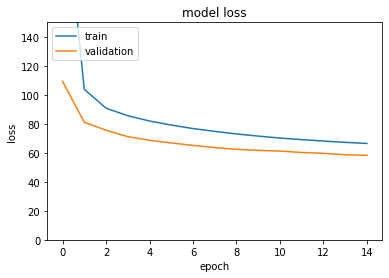

Saved training history to file: ./experiment_set_13\history\history_73_0.pkl


Iteration  74
Layer sizes = [64, 128, 64, 512], activation = relu, batch size = 1024, dropout = 0.5
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_254 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_133 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_255 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_134 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_256 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropou

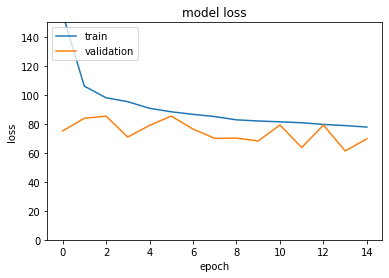

Saved training history to file: ./experiment_set_13\history\history_74_0.pkl


Iteration  75
Layer sizes = [512, 512, 512], activation = relu, batch size = 2048, dropout = 0.3
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_137 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_260 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_138 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_1

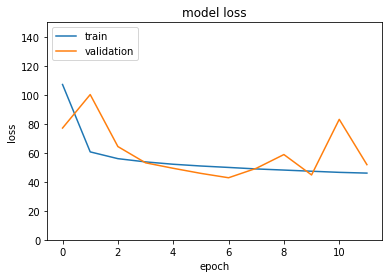

Saved training history to file: ./experiment_set_13\history\history_75_0.pkl


Iteration  76
Layer sizes = [256, 128, 256, 512], activation = relu, batch size = 1024, dropout = 0.3
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_140 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_141 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 256)               33024     
_________________________________________________________________
drop

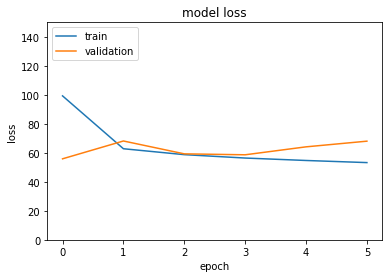

Saved training history to file: ./experiment_set_13\history\history_76_0.pkl


Iteration  77
Layer sizes = [256], activation = relu, batch size = 1024, dropout = 0.2
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_144 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 11s 3ms/step - loss: 238.4388 - val_loss: 89.5579
Epoch 2/15
3599/3599 [==============================] - 11s 3ms/step - loss: 81.8292 - val_loss: 69.2523
Epoc

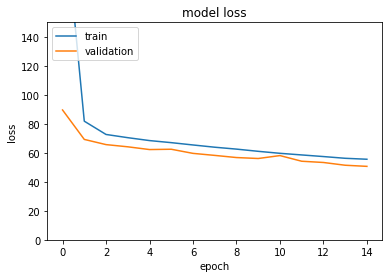

Saved training history to file: ./experiment_set_13\history\history_77_0.pkl


Iteration  78
Layer sizes = [64, 128, 128], activation = relu, batch size = 1024, dropout = 0.5
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_145 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_271 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_146 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_272 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_14

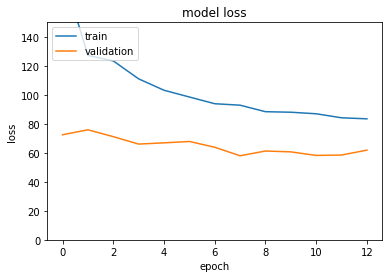

Saved training history to file: ./experiment_set_13\history\history_78_0.pkl


Iteration  79
Layer sizes = [128, 64], activation = tanh, batch size = 1024, dropout = 0.2
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_148 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_275 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_149 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 65        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
___________

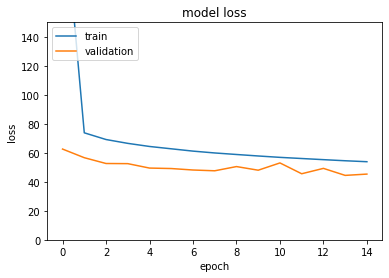

Saved training history to file: ./experiment_set_13\history\history_79_0.pkl


Iteration  80
Layer sizes = [512, 64, 128, 512], activation = tanh, batch size = 2048, dropout = 0.5
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_277 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_150 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_278 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_151 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_279 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropo

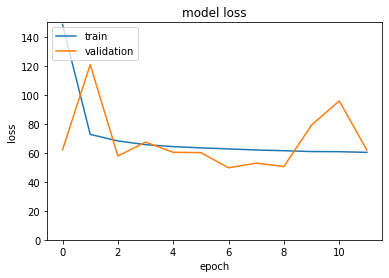

Saved training history to file: ./experiment_set_13\history\history_80_0.pkl


Iteration  81
Layer sizes = [512], activation = tanh, batch size = 512, dropout = 0.2
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_282 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_154 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 513       
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 22s 3ms/step - loss: 181.0582 - val_loss: 132.6107
Epoch 2/15
7197/7197 [==============================] - 22s 3ms/step - loss: 115.3615 - val_loss: 90.5867
E

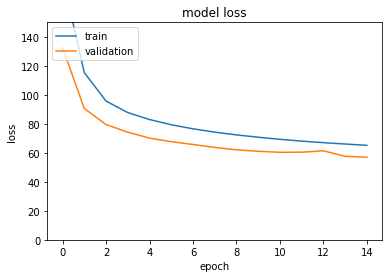

Saved training history to file: ./experiment_set_13\history\history_81_0.pkl


Iteration  82
Layer sizes = [512, 512, 128], activation = tanh, batch size = 512, dropout = 0.2
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_155 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_285 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_156 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_286 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_15

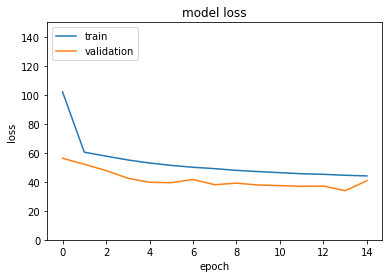

Saved training history to file: ./experiment_set_13\history\history_82_0.pkl


Iteration  83
Layer sizes = [512, 64, 512, 256], activation = tanh, batch size = 2048, dropout = 0.1
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_288 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_158 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_289 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_159 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_290 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropo

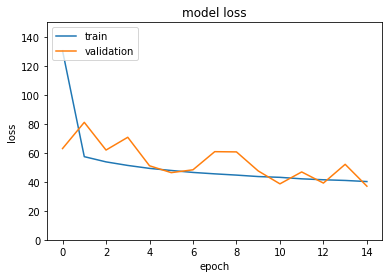

Saved training history to file: ./experiment_set_13\history\history_83_0.pkl


Iteration  84
Layer sizes = [128, 64, 512, 64], activation = relu, batch size = 2048, dropout = 0.3
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_162 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_294 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_163 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropou

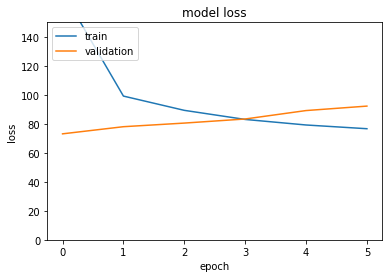

Saved training history to file: ./experiment_set_13\history\history_84_0.pkl


Iteration  85
Layer sizes = [512, 128], activation = relu, batch size = 1024, dropout = 0.3
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_298 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_166 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_299 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_167 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_300 (Dense)            (None, 1)                 129       
Total params: 75,521
Trainable params: 75,521
Non-trainable params: 0
__________

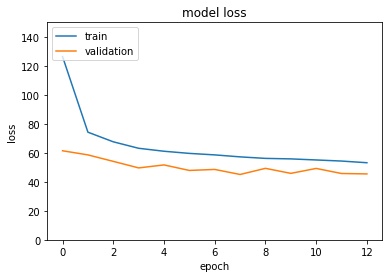

Saved training history to file: ./experiment_set_13\history\history_85_0.pkl


Iteration  86
Layer sizes = [128, 512, 256], activation = tanh, batch size = 1024, dropout = 0.2
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_168 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_169 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_303 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_1

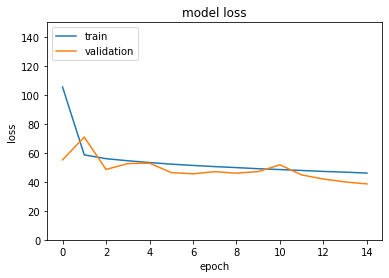

Saved training history to file: ./experiment_set_13\history\history_86_0.pkl


Iteration  87
Layer sizes = [256, 64, 512, 64], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_305 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_171 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_306 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_172 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropou

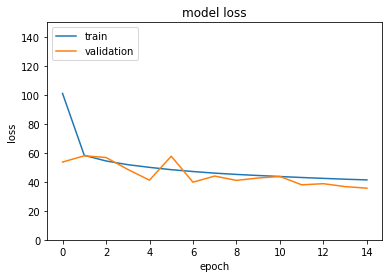

Saved training history to file: ./experiment_set_13\history\history_87_0.pkl


Iteration  88
Layer sizes = [64], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_310 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_175 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 22s 3ms/step - loss: 237.0746 - val_loss: 84.9700
Epoch 2/15
7197/7197 [==============================] - 21s 3ms/step - loss: 80.9256 - val_loss: 68.8252
Epoch 

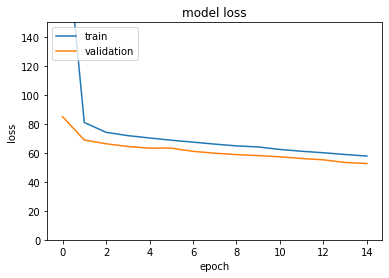

Saved training history to file: ./experiment_set_13\history\history_88_0.pkl


Iteration  89
Layer sizes = [128], activation = relu, batch size = 512, dropout = 0.3
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_176 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 22s 3ms/step - loss: 207.5013 - val_loss: 77.2919
Epoch 2/15
7197/7197 [==============================] - 22s 3ms/step - loss: 83.3578 - val_loss: 67.7452
Epoch

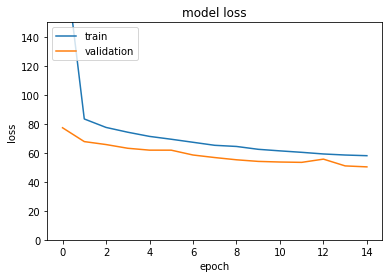

Saved training history to file: ./experiment_set_13\history\history_89_0.pkl


Iteration  90
Layer sizes = [128], activation = tanh, batch size = 2048, dropout = 0.2
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_314 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_177 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_315 (Dense)            (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 6s 3ms/step - loss: 411.7093 - val_loss: 163.4214
Epoch 2/15
1800/1800 [==============================] - 6s 3ms/step - loss: 160.2455 - val_loss: 147.2023
Epo

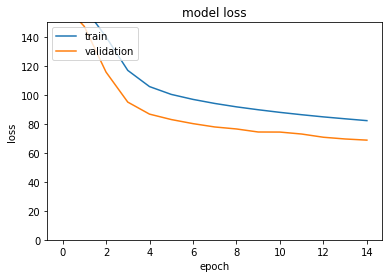

Saved training history to file: ./experiment_set_13\history\history_90_0.pkl


Iteration  91
Layer sizes = [128, 64, 128], activation = tanh, batch size = 512, dropout = 0.4
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_178 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_179 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_318 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_180

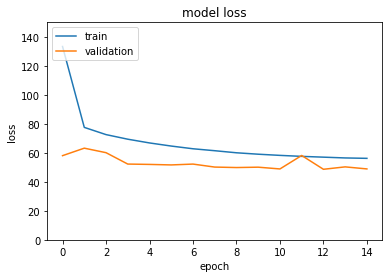

Saved training history to file: ./experiment_set_13\history\history_91_0.pkl


Iteration  92
Layer sizes = [256], activation = tanh, batch size = 1024, dropout = 0.5
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_181 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 12s 3ms/step - loss: 253.3057 - val_loss: 151.6837
Epoch 2/15
3599/3599 [==============================] - 11s 3ms/step - loss: 157.1491 - val_loss: 141.7351
E

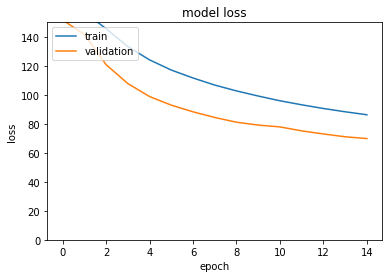

Saved training history to file: ./experiment_set_13\history\history_92_0.pkl


Iteration  93
Layer sizes = [64, 128], activation = relu, batch size = 2048, dropout = 0.2
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_322 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_182 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_183 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_324 (Dense)            (None, 1)                 129       
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_____________

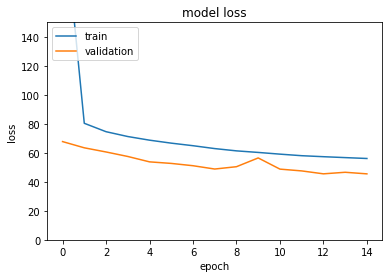

Saved training history to file: ./experiment_set_13\history\history_93_0.pkl


Iteration  94
Layer sizes = [64], activation = tanh, batch size = 2048, dropout = 0.3
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_325 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_184 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_326 (Dense)            (None, 1)                 65        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1800/1800 [==============================] - 6s 3ms/step - loss: 535.9088 - val_loss: 187.6330
Epoch 2/15
1800/1800 [==============================] - 5s 3ms/step - loss: 183.4131 - val_loss: 155.0008
Epoc

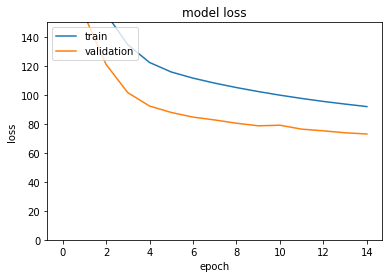

Saved training history to file: ./experiment_set_13\history\history_94_0.pkl


Iteration  95
Layer sizes = [64, 256, 64], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_327 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_328 (Dense)            (None, 256)               16640     
_________________________________________________________________
dense_329 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_330 (Dense)            (None, 1)                 65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - lo

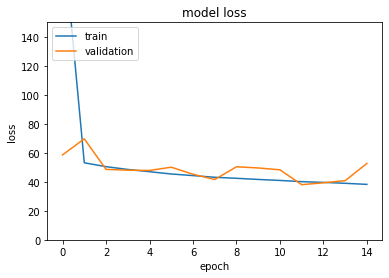

Saved training history to file: ./experiment_set_13\history\history_95_0.pkl


Iteration  96
Layer sizes = [256, 512, 128, 512], activation = relu, batch size = 2048, dropout = 0.4
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_185 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_332 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_186 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_333 (Dense)            (None, 128)               65664     
_________________________________________________________________
drop

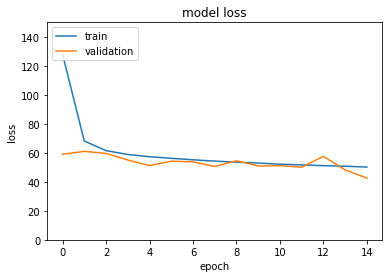

Saved training history to file: ./experiment_set_13\history\history_96_0.pkl


Iteration  97
Layer sizes = [512, 512, 512], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_189 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_190 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_1

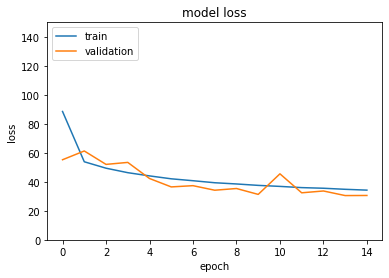

Saved training history to file: ./experiment_set_13\history\history_97_0.pkl


Iteration  98
Layer sizes = [256], activation = tanh, batch size = 512, dropout = 0.3
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_340 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_192 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 1)                 257       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 21s 3ms/step - loss: 199.9404 - val_loss: 133.2212
Epoch 2/15
7197/7197 [==============================] - 21s 3ms/step - loss: 124.1849 - val_loss: 96.0038
Epo

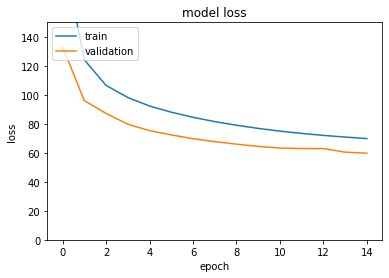

Saved training history to file: ./experiment_set_13\history\history_98_0.pkl


Iteration  99
Layer sizes = [256, 64, 512, 256], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_342 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_193 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_343 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_194 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_344 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropo

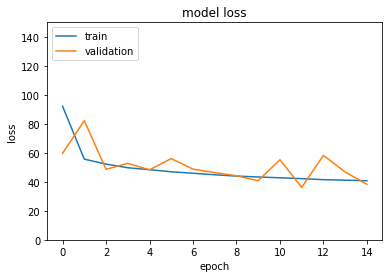

Saved training history to file: ./experiment_set_13\history\history_99_0.pkl


In [16]:
for i in range(ITERATIONS):
    num_layers = random.sample(num_hidden_layers, 1)[0]
    layer_sizes = [random.sample(hidden_layer_sizes, 1)[0] for _ in range(num_layers)]  
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_sizes, 1)[0]
    dropout = random.sample(dropout_percentages, 1)[0]

    print('\n\nIteration ', i)
    print(f'Layer sizes = {layer_sizes}, activation = {activation}, batch size = {batch_size}, dropout = {dropout}')
    
    # Prepare output path for weights
    initial_weights_path = os.path.join(output_path, "initial_weights")
    if not os.path.exists(initial_weights_path):
        os.makedirs(initial_weights_path)
        
    # Prepare output path for train history
    history_path = os.path.join(output_path, "history")
    if not os.path.exists(history_path):
        os.makedirs(history_path)
    
    mse_train, mse_train_std, mse_validation, mse_validation_std = test_mlp_configuration(
        x_train, y_train, NUM_TRIALS, i, EPOCHS, batch_size, layer_sizes, activation,
        dropout, initial_weights_path, history_path)
    
    with open(results_file, "a") as file:
        results_line = numbers_list_to_string(layer_sizes) + f",{activation},{batch_size},{dropout}"
        results_line += f",{mse_train},{mse_train_std},{mse_validation},{mse_validation_std}\n"
        file.write(results_line)

Saved object to file: ./experiment_set_13_1\scaler.pkl
Epoch 1/200
9245/9253 [============================>.] - ETA: 0s - loss: 118.6360
Epoch 00001: val_loss improved from inf to 51.08773, saving model to ./experiment_set_13_1\mlp_model_trained.h5
9253/9253 [==============================] - 26s 3ms/step - loss: 118.5842 - val_loss: 51.0877
Epoch 2/200
9239/9253 [============================>.] - ETA: 0s - loss: 50.4104
Epoch 00002: val_loss improved from 51.08773 to 48.77916, saving model to ./experiment_set_13_1\mlp_model_trained.h5
9253/9253 [==============================] - 26s 3ms/step - loss: 50.4096 - val_loss: 48.7792
Epoch 3/200
9240/9253 [============================>.] - ETA: 0s - loss: 46.5222
Epoch 00003: val_loss did not improve from 48.77916
9253/9253 [==============================] - 26s 3ms/step - loss: 46.5220 - val_loss: 56.2013
Epoch 4/200
9248/9253 [============================>.] - ETA: 0s - loss: 43.7033
Epoch 00004: val_loss did not improve from 48.77916
9253

9248/9253 [============================>.] - ETA: 0s - loss: 26.3479
Epoch 00033: val_loss did not improve from 25.24512
9253/9253 [==============================] - 26s 3ms/step - loss: 26.3477 - val_loss: 26.6087
Epoch 34/200
9247/9253 [============================>.] - ETA: 0s - loss: 26.2182
Epoch 00034: val_loss did not improve from 25.24512
9253/9253 [==============================] - 26s 3ms/step - loss: 26.2174 - val_loss: 31.1042
Epoch 35/200
9252/9253 [============================>.] - ETA: 0s - loss: 25.9463
Epoch 00035: val_loss did not improve from 25.24512
9253/9253 [==============================] - 26s 3ms/step - loss: 25.9464 - val_loss: 25.6124
Epoch 36/200
9235/9253 [============================>.] - ETA: 0s - loss: 25.7583
Epoch 00036: val_loss did not improve from 25.24512
9253/9253 [==============================] - 25s 3ms/step - loss: 25.7587 - val_loss: 25.6224
Epoch 37/200
9251/9253 [============================>.] - ETA: 0s - loss: 25.5917
Epoch 00037: val_lo

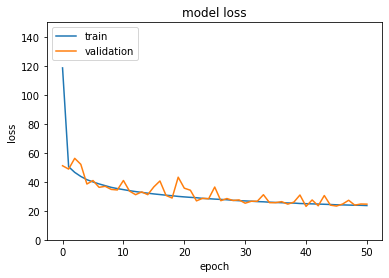

Saved training history to file: ./experiment_set_13_1\history.pkl
Test set:
MSE: 61.45
RMSE: 7.84
CMAPSS score: 1.77



In [14]:
##################################################
# Retrain on entire training set (experiment 13_1)
##################################################
batch_size = 512
epochs = 200
layer_sizes = [128, 64, 64]
activation = 'tanh'

# Train-validation split for early stopping
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, 
                                                                          y_train, 
                                                                          test_size=0.1, 
                                                                          random_state=seed)


# Standardization
scaler_file = os.path.join(output_path, 'scaler.pkl')
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_split)
x_val_scaled = scaler.transform(x_val_split)
input_dim = x_train_scaled.shape[1]
save_object(scaler, scaler_file)

# Create model
weights_file = os.path.join(output_path, 'mlp_initial_weights.h5')
model_path = os.path.join(output_path, 'mlp_model_trained.h5')
        
model = create_mlp_model(input_dim, layer_sizes, activation=activation,
                         output_weights_file=weights_file)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=2, 
                     save_best_only=True)

# Train model
history = train_model_existing_weights(model, weights_file, 
                                       x_train_scaled, y_train_split, 
                                       x_val_scaled, y_val_split, 
                                       batch_size=batch_size, 
                                       epochs=epochs, 
                                       callbacks=[es, mc])

history_file = os.path.join(output_path, "history.pkl")
plot_loss_curves(history.history)
save_history(history, history_file)

# Performance evaluation
x_test_scaled = scaler.transform(x_test)

loaded_model = load_model(model_path)
predictions_test = loaded_model.predict(x_test_scaled).flatten()
mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

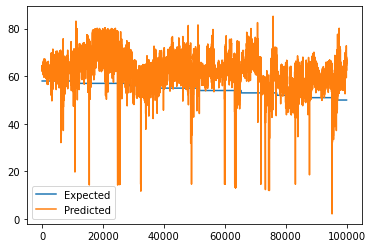

In [17]:
plot_rul(y_test[:100000], predictions_test[:100000])

In [18]:
###################################
# Random search (experiment set 14)
###################################
ITERATIONS = 50
EPOCHS = 15
NUM_TRIALS = 1

hidden_layer_sizes = [64, 128, 256, 512]
num_hidden_layers = [2, 3]
activation_functions = ['tanh', 'relu']
batch_sizes = [512, 1024]
dropout_percentages = [0.0, 0.05, 0.1]
input_dim = x_train.shape[1]

In [19]:
results_file = os.path.join(output_path, "parameter_search.csv")
with open(results_file, "w") as file:
    file.write("layers,num_layers,activation,batch_size,dropout,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std\n")



Iteration  0
Layer sizes = [64, 512], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 35,009
Trainable params: 35,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 24s 3ms/step - loss: 103.9701 - val_loss: 57.4890
Epoch 2/15
7197/7197 [==============================] - 24s 3ms/step - loss: 53.6943 - val_loss: 51.3764
Epoch 3/15
7197/7197 [==============================] - 23s 3ms/step - loss: 5

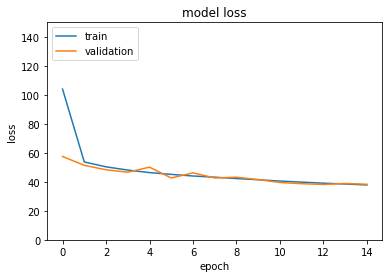

Saved training history to file: ./experiment_set_14\history\history_0_0.pkl


Iteration  1
Layer sizes = [128, 64], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 12s 3ms/step - loss: 215.8084 - val_loss: 59.3490
Epoch 2/15
3599/3599 [==============================] - 11s 3ms/step - loss: 53.6204 - val_loss: 54.0244
E

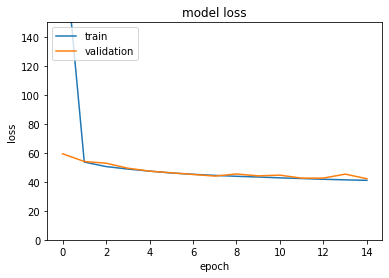

Saved training history to file: ./experiment_set_14\history\history_1_0.pkl


Iteration  2
Layer sizes = [256, 64, 128], activation = relu, batch size = 1024, dropout = 0.05
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               4864      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_2 (D

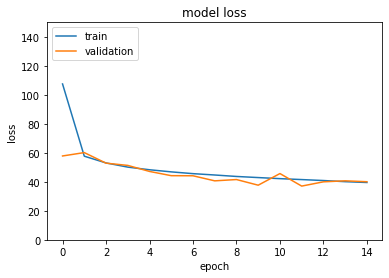

Saved training history to file: ./experiment_set_14\history\history_2_0.pkl


Iteration  3
Layer sizes = [128, 256], activation = tanh, batch size = 512, dropout = 0.05
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 35,713
Trainable params: 35,713
Non-trainable params: 0
_____________

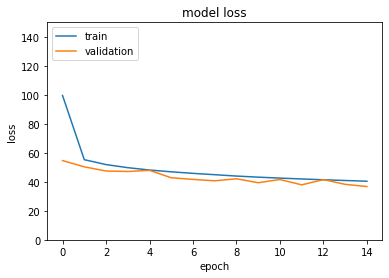

Saved training history to file: ./experiment_set_14\history\history_3_0.pkl


Iteration  4
Layer sizes = [256, 256], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 70,913
Trainable params: 70,913
Non-trainable params: 0
______________

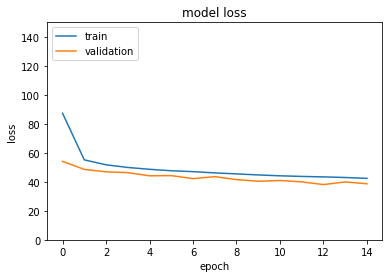

Saved training history to file: ./experiment_set_14\history\history_4_0.pkl


Iteration  5
Layer sizes = [64, 512, 64], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_9 (Dro

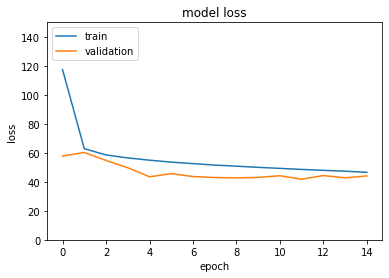

Saved training history to file: ./experiment_set_14\history\history_5_0.pkl


Iteration  6
Layer sizes = [64, 64], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 3ms/step - loss: 224.8456 - val_loss: 64.0651
Epoch 2/15
3599/3599 [==============================] - 12s 3ms/step - loss: 57.8293 - val_loss: 55.3258
Epoc

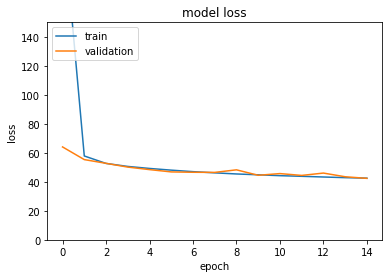

Saved training history to file: ./experiment_set_14\history\history_6_0.pkl


Iteration  7
Layer sizes = [64, 512], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 513       
Total params: 35,009
Trainable params: 35,009
Non-trainable params: 0
______________

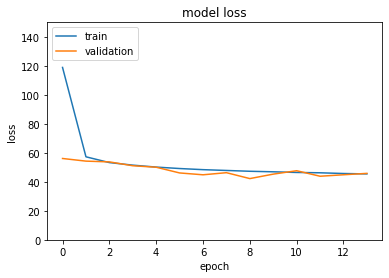

Saved training history to file: ./experiment_set_14\history\history_7_0.pkl


Iteration  8
Layer sizes = [128, 256, 256], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_14 (

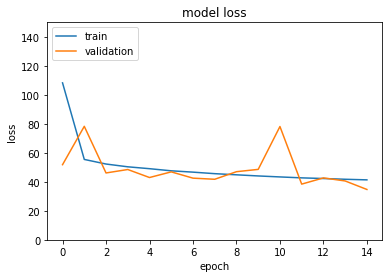

Saved training history to file: ./experiment_set_14\history\history_8_0.pkl


Iteration  9
Layer sizes = [128, 128], activation = tanh, batch size = 1024, dropout = 0.05
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 19,073
Trainable params: 19,073
Non-trainable params: 0
___________

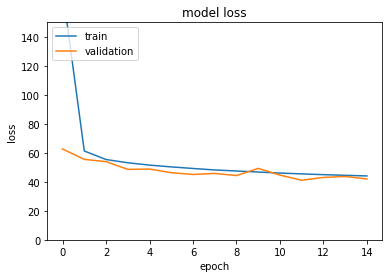

Saved training history to file: ./experiment_set_14\history\history_9_0.pkl


Iteration  10
Layer sizes = [128, 256, 64], activation = tanh, batch size = 512, dropout = 0.05
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_19 

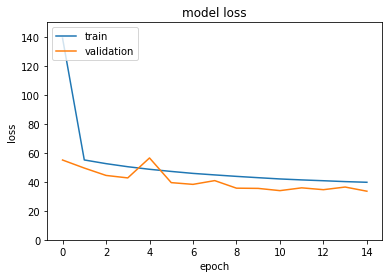

Saved training history to file: ./experiment_set_14\history\history_10_0.pkl


Iteration  11
Layer sizes = [256, 64, 128], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_22 

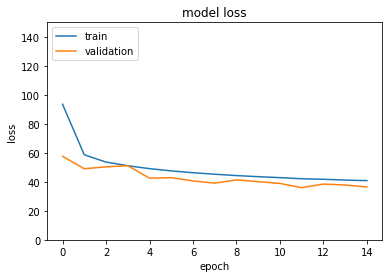

Saved training history to file: ./experiment_set_14\history\history_11_0.pkl


Iteration  12
Layer sizes = [512, 512, 128], activation = relu, batch size = 512, dropout = 0.0
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 512)               9728      
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_46 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 129       
Total params: 338,177
Trainable params: 338,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 35s 5ms/step -

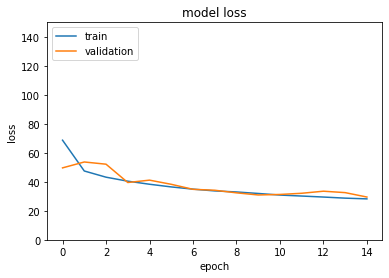

Saved training history to file: ./experiment_set_14\history\history_12_0.pkl


Iteration  13
Layer sizes = [512, 512, 256], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               9728      
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25

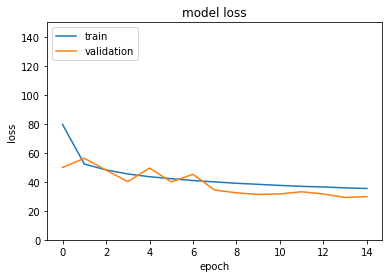

Saved training history to file: ./experiment_set_14\history\history_13_0.pkl


Iteration  14
Layer sizes = [64, 64, 64], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_28 (D

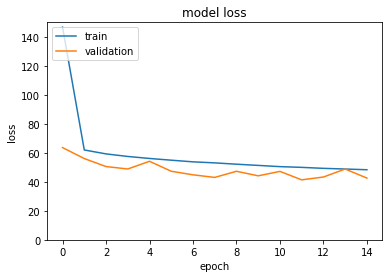

Saved training history to file: ./experiment_set_14\history\history_14_0.pkl


Iteration  15
Layer sizes = [64, 512, 512], activation = relu, batch size = 1024, dropout = 0.1
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_31

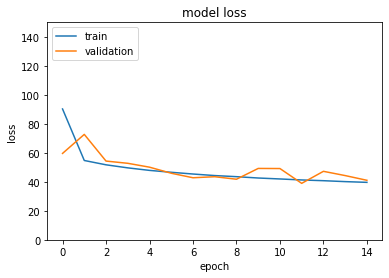

Saved training history to file: ./experiment_set_14\history\history_15_0.pkl


Iteration  16
Layer sizes = [64, 256], activation = relu, batch size = 512, dropout = 0.05
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 257       
Total params: 18,113
Trainable params: 18,113
Non-trainable params: 0
___________

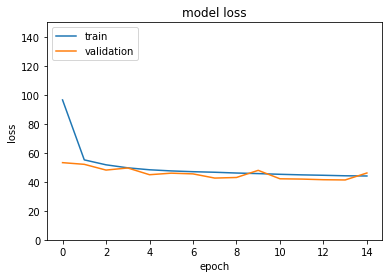

Saved training history to file: ./experiment_set_14\history\history_16_0.pkl


Iteration  17
Layer sizes = [128, 512, 64], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_36 

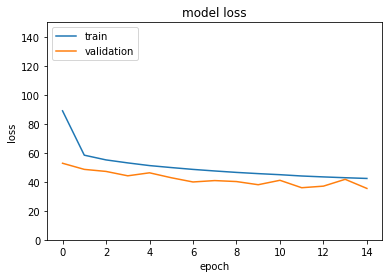

Saved training history to file: ./experiment_set_14\history\history_17_0.pkl


Iteration  18
Layer sizes = [256, 128], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_68 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 129       
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - loss: 145.9976 - val_loss: 63.7947
Epoch 2/15
3599/3599 [==============================] - 13s 4ms/step - loss: 57.8402 - val_loss: 60.76

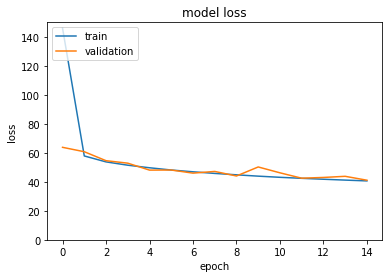

Saved training history to file: ./experiment_set_14\history\history_18_0.pkl


Iteration  19
Layer sizes = [256, 512], activation = tanh, batch size = 512, dropout = 0.05
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_38 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 513       
Total params: 136,961
Trainable params: 136,961
Non-trainable params: 0
________

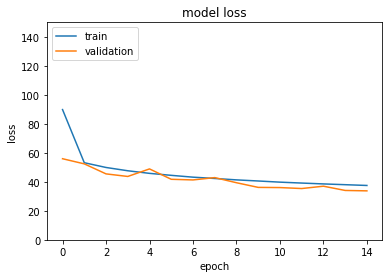

Saved training history to file: ./experiment_set_14\history\history_19_0.pkl


Iteration  20
Layer sizes = [128, 64, 128], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_41 

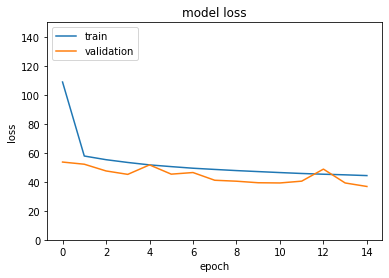

Saved training history to file: ./experiment_set_14\history\history_20_0.pkl


Iteration  21
Layer sizes = [64, 128, 128], activation = relu, batch size = 512, dropout = 0.05
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_44

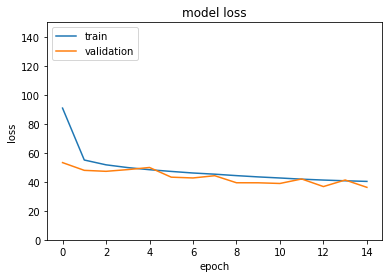

Saved training history to file: ./experiment_set_14\history\history_21_0.pkl


Iteration  22
Layer sizes = [128, 128, 256], activation = relu, batch size = 1024, dropout = 0.05
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_

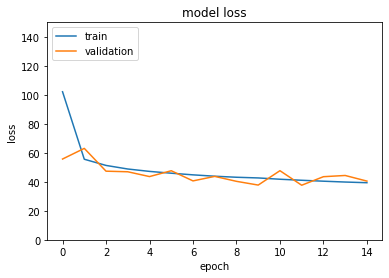

Saved training history to file: ./experiment_set_14\history\history_22_0.pkl


Iteration  23
Layer sizes = [64, 128, 128], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_86 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_87 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 129       
Total params: 26,177
Trainable params: 26,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - l

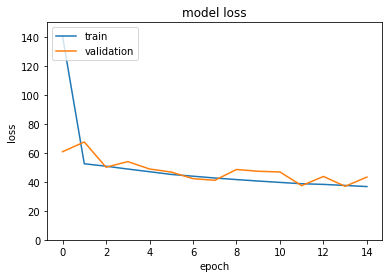

Saved training history to file: ./experiment_set_14\history\history_23_0.pkl


Iteration  24
Layer sizes = [128, 64], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_90 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 65        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 24s 3ms/step - loss: 138.4296 - val_loss: 53.3310
Epoch 2/15
7197/7197 [==============================] - 24s 3ms/step - loss: 51.6038 - val_loss: 51.9072

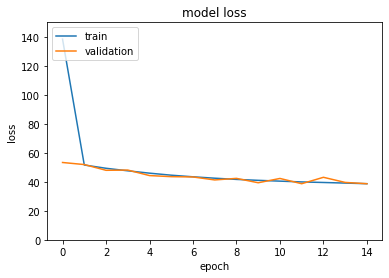

Saved training history to file: ./experiment_set_14\history\history_24_0.pkl


Iteration  25
Layer sizes = [64, 256], activation = tanh, batch size = 512, dropout = 0.05
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 257       
Total params: 18,113
Trainable params: 18,113
Non-trainable params: 0
___________

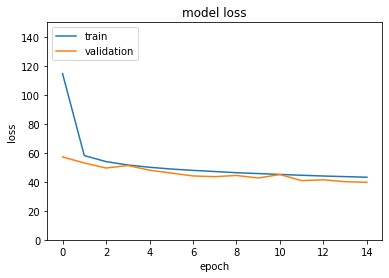

Saved training history to file: ./experiment_set_14\history\history_25_0.pkl


Iteration  26
Layer sizes = [128, 128, 512], activation = tanh, batch size = 1024, dropout = 0.05
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_

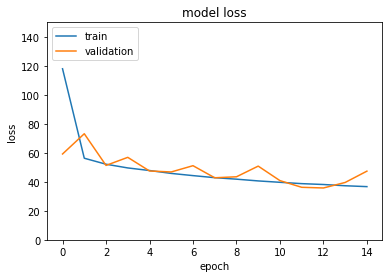

Saved training history to file: ./experiment_set_14\history\history_26_0.pkl


Iteration  27
Layer sizes = [64, 64], activation = relu, batch size = 1024, dropout = 0.05
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_____________

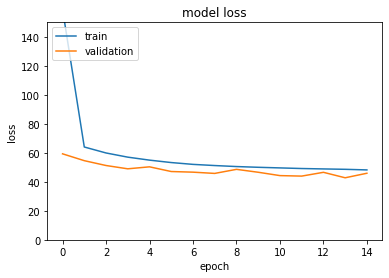

Saved training history to file: ./experiment_set_14\history\history_27_0.pkl


Iteration  28
Layer sizes = [512, 64, 64], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_55 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_57 

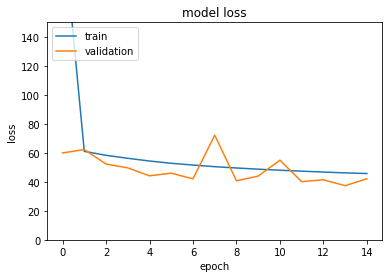

Saved training history to file: ./experiment_set_14\history\history_28_0.pkl


Iteration  29
Layer sizes = [64, 128, 128], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_107 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_108 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 129       
Total params: 26,177
Trainable params: 26,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 14s 4ms/step - l

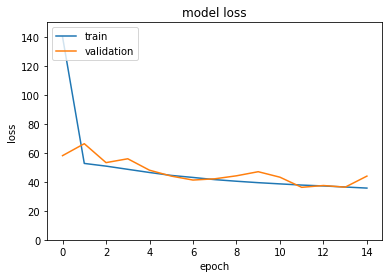

Saved training history to file: ./experiment_set_14\history\history_29_0.pkl


Iteration  30
Layer sizes = [128, 256, 512], activation = tanh, batch size = 512, dropout = 0.05
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_6

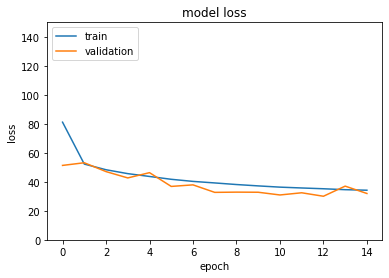

Saved training history to file: ./experiment_set_14\history\history_30_0.pkl


Iteration  31
Layer sizes = [64, 64], activation = tanh, batch size = 512, dropout = 0.0
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_115 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 24s 3ms/step - loss: 148.3407 - val_loss: 53.7655
Epoch 2/15
7197/7197 [==============================] - 25s 3ms/step - loss: 52.2266 - val_loss: 51.2828
Ep

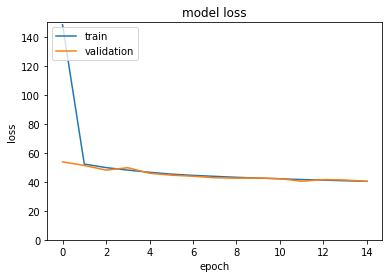

Saved training history to file: ./experiment_set_14\history\history_31_0.pkl


Iteration  32
Layer sizes = [512, 512, 128], activation = relu, batch size = 512, dropout = 0.0
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 512)               9728      
_________________________________________________________________
dense_118 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_119 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 129       
Total params: 338,177
Trainable params: 338,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 37s 5ms/step -

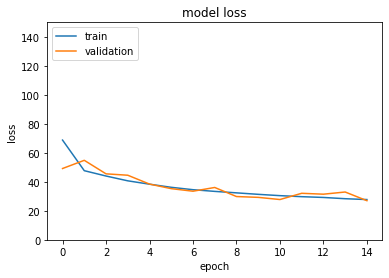

Saved training history to file: ./experiment_set_14\history\history_32_0.pkl


Iteration  33
Layer sizes = [64, 512, 256], activation = relu, batch size = 1024, dropout = 0.05
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_6

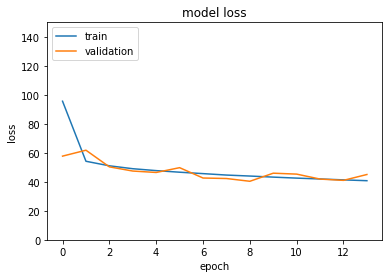

Saved training history to file: ./experiment_set_14\history\history_33_0.pkl


Iteration  34
Layer sizes = [128, 128, 256], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_66

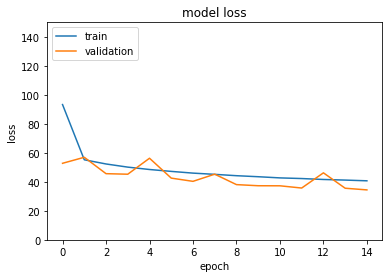

Saved training history to file: ./experiment_set_14\history\history_34_0.pkl


Iteration  35
Layer sizes = [256, 64], activation = tanh, batch size = 1024, dropout = 0.1
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_68 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 65        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
___________

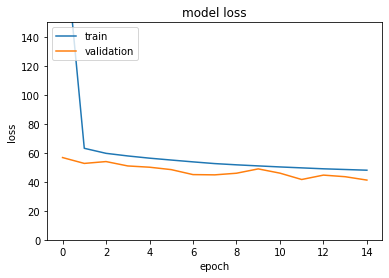

Saved training history to file: ./experiment_set_14\history\history_35_0.pkl


Iteration  36
Layer sizes = [64, 64], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_69 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_70 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_______________

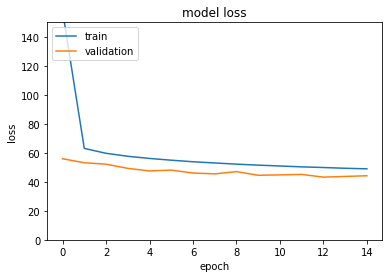

Saved training history to file: ./experiment_set_14\history\history_36_0.pkl


Iteration  37
Layer sizes = [128, 512], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_72 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 513       
Total params: 68,993
Trainable params: 68,993
Non-trainable params: 0
___________

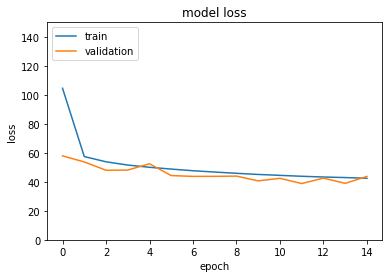

Saved training history to file: ./experiment_set_14\history\history_37_0.pkl


Iteration  38
Layer sizes = [64, 512], activation = relu, batch size = 1024, dropout = 0.0
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_139 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 513       
Total params: 35,009
Trainable params: 35,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 14s 4ms/step - loss: 109.2269 - val_loss: 54.6025
Epoch 2/15
3599/3599 [==============================] - 14s 4ms/step - loss: 50.8153 - val_loss: 54.272

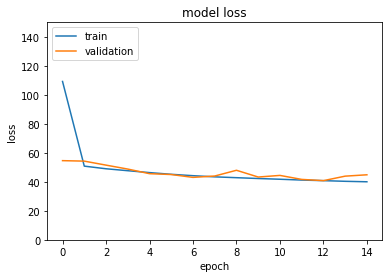

Saved training history to file: ./experiment_set_14\history\history_38_0.pkl


Iteration  39
Layer sizes = [128, 256, 512], activation = tanh, batch size = 1024, dropout = 0.05
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 128)               2432      
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_

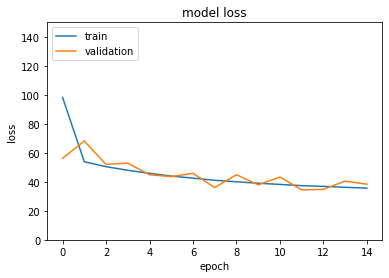

Saved training history to file: ./experiment_set_14\history\history_39_0.pkl


Iteration  40
Layer sizes = [64, 64, 512], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropout_78 (

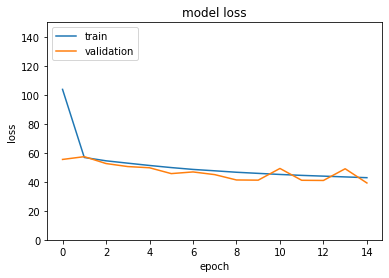

Saved training history to file: ./experiment_set_14\history\history_40_0.pkl


Iteration  41
Layer sizes = [256, 128], activation = relu, batch size = 512, dropout = 0.0
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 256)               4864      
_________________________________________________________________
dense_150 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 129       
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 25s 3ms/step - loss: 83.9825 - val_loss: 51.8425
Epoch 2/15
7197/7197 [==============================] - 25s 3ms/step - loss: 49.5855 - val_loss: 48.3511

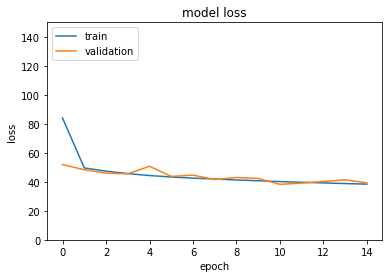

Saved training history to file: ./experiment_set_14\history\history_41_0.pkl


Iteration  42
Layer sizes = [256, 128, 512], activation = relu, batch size = 512, dropout = 0.1
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_80 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_81

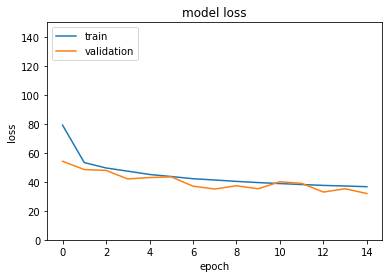

Saved training history to file: ./experiment_set_14\history\history_42_0.pkl


Iteration  43
Layer sizes = [64, 128, 256], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_84 

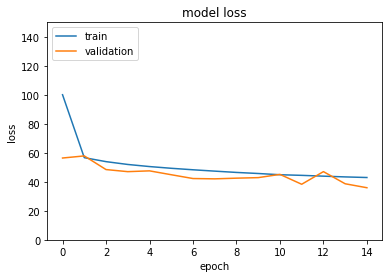

Saved training history to file: ./experiment_set_14\history\history_43_0.pkl


Iteration  44
Layer sizes = [256, 256], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 256)               4864      
_________________________________________________________________
dense_161 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 257       
Total params: 70,913
Trainable params: 70,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 15s 4ms/step - loss: 116.1926 - val_loss: 58.8279
Epoch 2/15
3599/3599 [==============================] - 15s 4ms/step - loss: 52.1013 - val_loss: 57.47

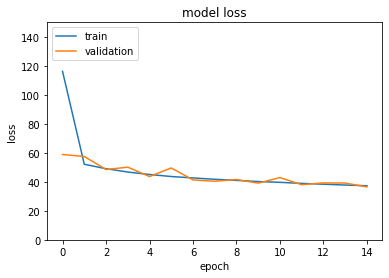

Saved training history to file: ./experiment_set_14\history\history_44_0.pkl


Iteration  45
Layer sizes = [512, 256, 64], activation = tanh, batch size = 1024, dropout = 0.05
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_85 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_86 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_8

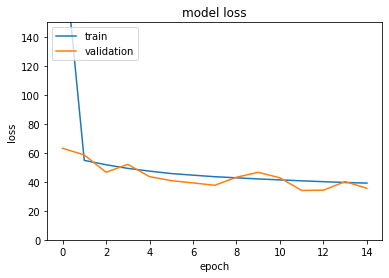

Saved training history to file: ./experiment_set_14\history\history_45_0.pkl


Iteration  46
Layer sizes = [64, 256], activation = tanh, batch size = 1024, dropout = 0.0
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_168 (Dense)            (None, 256)               16640     
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 257       
Total params: 18,113
Trainable params: 18,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3599/3599 [==============================] - 13s 4ms/step - loss: 157.0331 - val_loss: 61.6213
Epoch 2/15
3599/3599 [==============================] - 13s 4ms/step - loss: 55.7949 - val_loss: 57.254

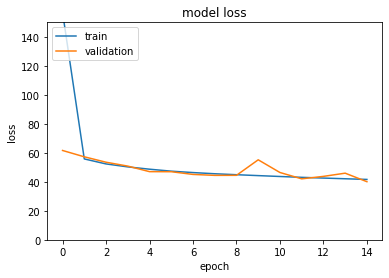

Saved training history to file: ./experiment_set_14\history\history_46_0.pkl


Iteration  47
Layer sizes = [512, 64, 64], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 512)               9728      
_________________________________________________________________
dropout_88 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_89 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_172 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_90 (

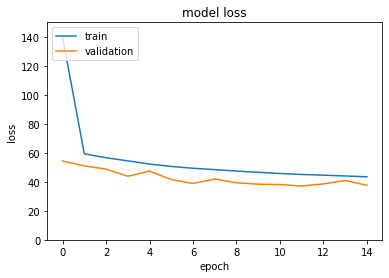

Saved training history to file: ./experiment_set_14\history\history_47_0.pkl


Iteration  48
Layer sizes = [256, 128], activation = relu, batch size = 512, dropout = 0.0
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 256)               4864      
_________________________________________________________________
dense_175 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 129       
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7197/7197 [==============================] - 25s 3ms/step - loss: 84.5010 - val_loss: 50.7761
Epoch 2/15
7197/7197 [==============================] - 25s 3ms/step - loss: 49.4105 - val_loss: 48.1554

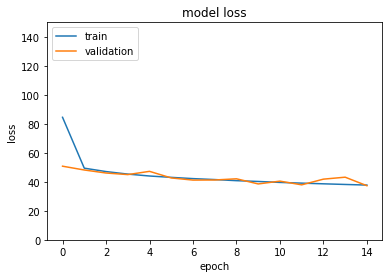

Saved training history to file: ./experiment_set_14\history\history_48_0.pkl


Iteration  49
Layer sizes = [256, 64, 256], activation = tanh, batch size = 512, dropout = 0.1
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 256)               4864      
_________________________________________________________________
dropout_91 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_92 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 256)               16640     
_________________________________________________________________
dropout_93 

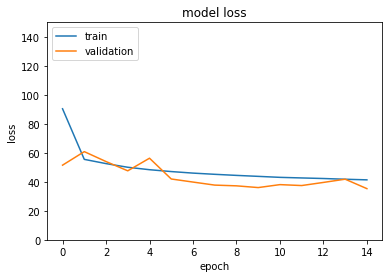

Saved training history to file: ./experiment_set_14\history\history_49_0.pkl


In [20]:
for i in range(ITERATIONS):
    num_layers = random.sample(num_hidden_layers, 1)[0]
    layer_sizes = [random.sample(hidden_layer_sizes, 1)[0] for _ in range(num_layers)]  
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_sizes, 1)[0]
    dropout = random.sample(dropout_percentages, 1)[0]

    print('\n\nIteration ', i)
    print(f'Layer sizes = {layer_sizes}, activation = {activation}, batch size = {batch_size}, dropout = {dropout}')
    
    # Prepare output path for weights
    initial_weights_path = os.path.join(output_path, "initial_weights")
    if not os.path.exists(initial_weights_path):
        os.makedirs(initial_weights_path)
        
    # Prepare output path for train history
    history_path = os.path.join(output_path, "history")
    if not os.path.exists(history_path):
        os.makedirs(history_path)
    
    mse_train, mse_train_std, mse_validation, mse_validation_std = test_mlp_configuration(
        x_train, y_train, NUM_TRIALS, i, EPOCHS, batch_size, layer_sizes, activation,
        dropout, initial_weights_path, history_path)
    
    with open(results_file, "a") as file:
        results_line = numbers_list_to_string(layer_sizes) + f",{num_layers},{activation},{batch_size},{dropout}"
        results_line += f",{mse_train},{mse_train_std},{mse_validation},{mse_validation_std}\n"
        file.write(results_line)